In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers,models
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [2]:
DATASET_COLUMNS=['sentiment','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
data.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
data = data.dropna()
data.reset_index(inplace=True)

## **Exploratory** **Data** **Analysis**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   index      1600000 non-null  int64 
 1   sentiment  1600000 non-null  int64 
 2   ids        1600000 non-null  int64 
 3   date       1600000 non-null  object
 4   flag       1600000 non-null  object
 5   user       1600000 non-null  object
 6   text       1600000 non-null  object
dtypes: int64(3), object(4)
memory usage: 85.4+ MB


In [5]:
data.dtypes

index         int64
sentiment     int64
ids           int64
date         object
flag         object
user         object
text         object
dtype: object

In [6]:
data['sentiment'].unique()

array([0, 4])

In [7]:
data['sentiment'].nunique()

2

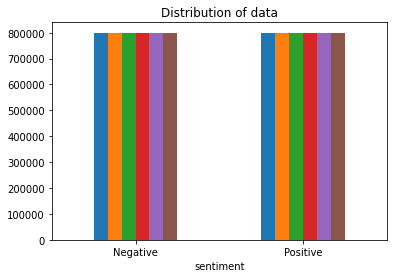

In [8]:
# Plotting the distribution for dataset.
ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiments = list(data['text']), list(data['sentiment'])

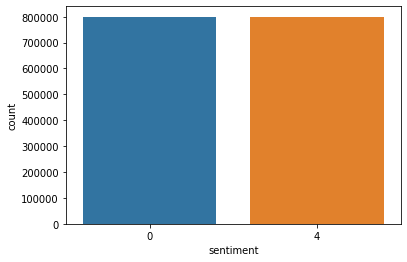

In [9]:
sns.countplot(x='sentiment', data=data)

# **Text Preprocessing**

In [10]:
dirtyData=data[['text','sentiment']]

In [11]:
dirtyData['sentiment'] = dirtyData['sentiment'].replace(4,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
dirtyData['sentiment'].unique()

array([0, 1])

In [13]:
positive = dirtyData[dirtyData['sentiment'] == 1]
negative = dirtyData[dirtyData['sentiment'] == 0]

In [14]:
#taking 50 000 data points so as to run the model quicker with limited computing resources
positive =positive.iloc[:int(25000)]
negative =negative.iloc[:int(25000)]

In [15]:
dataset = pd.concat([positive, negative])

In [16]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

24995    is sad that it is raining... no softball for m...
24996                               last day of vacation. 
24997    good morning! its a beautiful day, too bad i'm...
24998    night all. love yas. hahahahahah btw... vodka ...
24999       why do i have to go back to school tomorrow?? 
Name: text, dtype: object

In [17]:
import nltk
import re
from nltk.corpus import stopwords

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords.words('english')])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [20]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

24995                           sad raining softball today
24996                                    last day vacation
24997    good morning beautiful day bad im gonna spendi...
24998        night all love yas hahahahahah btw vodka evil
24999                              go back school tomorrow
Name: text, dtype: object

In [21]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

24995                           sad raining softball today
24996                                    last day vacation
24997    good morning beautiful day bad im gonna spendi...
24998        night all love yas hahahahahah btw vodka evil
24999                              go back school tomorrow
Name: text, dtype: object

In [22]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

24995                           sad raining softball today
24996                                    last day vacation
24997    good morning beautiful day bad im gonna spendi...
24998        night all love yas hahahahahah btw vodka evil
24999                              go back school tomorrow
Name: text, dtype: object

In [23]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

24995                           sad raining softball today
24996                                    last day vacation
24997    good morning beautiful day bad im gonna spendi...
24998        night all love yas hahahahahah btw vodka evil
24999                              go back school tomorrow
Name: text, dtype: object

In [24]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].tail()

24995                      [sad, raining, softball, today]
24996                                [last, day, vacation]
24997    [good, morning, beautiful, day, bad, im, gonna...
24998    [night, all, love, yas, hahahahahah, btw, vodk...
24999                         [go, back, school, tomorrow]
Name: text, dtype: object

In [25]:
dataset['text'].tail()

24995                      [sad, raining, softball, today]
24996                                [last, day, vacation]
24997    [good, morning, beautiful, day, bad, im, gonna...
24998    [night, all, love, yas, hahahahahah, btw, vodk...
24999                         [go, back, school, tomorrow]
Name: text, dtype: object

In [26]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].tail()

24995                      [sad, raining, softball, today]
24996                                [last, day, vacation]
24997    [good, morning, beautiful, day, bad, im, gonna...
24998    [night, all, love, yas, hahahahahah, btw, vodk...
24999                         [go, back, school, tomorrow]
Name: text, dtype: object

In [27]:
dataset['text']

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
                                ...                        
24995                       [sad, raining, softball, today]
24996                                 [last, day, vacation]
24997     [good, morning, beautiful, day, bad, im, gonna...
24998     [night, all, love, yas, hahahahahah, btw, vodk...
24999                          [go, back, school, tomorrow]
Name: text, Length: 50000, dtype: object

In [28]:
dataset.reset_index(inplace=True)

In [29]:
def combine(data):
  return ' '.join(data)
  
dataset['text'] = dataset['text'].apply(lambda x: combine(x))
dataset.head()

,index,text,sentiment
0,800000,love healthuandpets u guys r best,1
1,800001,im meeting one besties tonight cant wait girl ...,1
2,800002,darealsunisakim thanks twitter add sunisa got ...,1
3,800003,sick really cheap hurts much eat real food plu...,1
4,800004,lovesbrooklyn effect everyone,1


In [30]:
dataset['text2'] = dataset['text'].copy()

In [31]:
x1 = dataset['text2']
y1 = dataset['sentiment']

# **Traditional Machine learning with TFIDF vectorizer**

In [32]:
from sklearn.model_selection import train_test_split
x_train1,x_test1,y_train1,y_test1 = train_test_split(x1,y1,test_size = 0.3,random_state = 42)

In [33]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x_train1)


TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [34]:
x_train1 = vectoriser.transform(x_train1)
x_test1  = vectoriser.transform(x_test1)

### **BernoulliNB**

In [35]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
bayesModel = BernoulliNB()
bayesModel.fit(x_train1, y_train1)
y_pred1 = bayesModel.predict(x_test1)

In [37]:
y_pred1

array([0, 1, 0, ..., 0, 0, 0])

In [38]:
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      7474
           1       0.77      0.71      0.73      7526

    accuracy                           0.74     15000
   macro avg       0.75      0.74      0.74     15000
weighted avg       0.75      0.74      0.74     15000



In [39]:
confusion_matrix(y_test1, y_pred1)

array([[5846, 1628],
       [2214, 5312]])

### **Support** **Vector** **Machine**

In [40]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train1, y_train1)
y_pred2 = SVCmodel.predict(x_test1)

In [41]:
print(classification_report(y_test1, y_pred2))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      7474
           1       0.76      0.74      0.75      7526

    accuracy                           0.75     15000
   macro avg       0.75      0.75      0.75     15000
weighted avg       0.75      0.75      0.75     15000



In [42]:
confusion_matrix(y_test1, y_pred2)

array([[5722, 1752],
       [1950, 5576]])

# **Deep** **Learning** **with** **Embedded** **layers**

In [43]:

def combine(data):
  return ' '.join(data)
  
dataset['text'] = dataset['text'].apply(lambda x: combine(x))
dataset.head()

,index,text,sentiment,text2
0,800000,l o v e h e a l t h u a n d p e t s u g ...,1,love healthuandpets u guys r best
1,800001,i m m e e t i n g o n e b e s t i e s ...,1,im meeting one besties tonight cant wait girl ...
2,800002,d a r e a l s u n i s a k i m t h a n k s ...,1,darealsunisakim thanks twitter add sunisa got ...
3,800003,s i c k r e a l l y c h e a p h u r t s ...,1,sick really cheap hurts much eat real food plu...
4,800004,l o v e s b r o o k l y n e f f e c t e v ...,1,lovesbrooklyn effect everyone


In [44]:
messages = dataset['text2']

In [45]:
corpus = []
for i in range(0,len(messages)):
  corpus.append(messages[i])
print(corpus)


['love healthuandpets u guys r best', 'im meeting one besties tonight cant wait girl talk', 'darealsunisakim thanks twitter add sunisa got meet hin show dc area sweetheart', 'sick really cheap hurts much eat real food plus friends make soup', 'lovesbrooklyn effect everyone', 'productoffear tell burst laughing really loud thanks making come sulk', 'rkeithhill thans response ihad already find answer', 'keepinupwkris jealous hope great time vegas like acms love show', 'tommcfly ah congrats mr fletcher finally joining twitter', 'evoip responded stupid cat helping type forgive errors', 'crazy day school hours straiiight watch hills spencerpratt told too ha happy birthday jb', 'naughtyhaughty forget two half men love show', 'nileyjileyluver haha worry get hang it', 'soundwav least one feeling lost may cause many later usual nights already addicting', 'lutheranlucciol make sure dm post link video ltlolgtso miss better get permission blessing first', 'added tweetie new iphone', 'michellardi re

In [46]:
voc_size = 5000

In [47]:
y = dataset['sentiment']

In [48]:
onehot_rep = [one_hot(words,voc_size) for words in corpus]
sent_length = 20
embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=sent_length)
len(embedded_docs)

50000

In [49]:
from sklearn.model_selection import train_test_split
x_train2,x_test2,y_train2,y_test2 = train_test_split(embedded_docs,y,test_size = 0.3,random_state = 42)

### **Bidirectional LSTM Model**

In [50]:
#creating the model
embedding_vector_features = 800
model = Sequential()
#adding embedding layer w vector features of 100 those features are wat will give our text data weight and similarity
#to other words in the dict basically turning it to a vector
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100,return_sequences =True)))
model.add(Bidirectional(LSTM(50,return_sequences =True)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [51]:
model.fit(x_train2,y_train2,validation_data=(x_test2,y_test2),epochs=20,batch_size = 32)

Epoch 1/20
1094/1094 [==============================] - 57s 43ms/step - loss: 0.5836 - accuracy: 0.6900 - val_loss: 0.5529 - val_accuracy: 0.7218
Epoch 2/20
1094/1094 [==============================] - 44s 41ms/step - loss: 0.5008 - accuracy: 0.7562 - val_loss: 0.5695 - val_accuracy: 0.7116
Epoch 3/20
1094/1094 [==============================] - 44s 41ms/step - loss: 0.4450 - accuracy: 0.7905 - val_loss: 0.6112 - val_accuracy: 0.7048
Epoch 4/20
1094/1094 [==============================] - 44s 40ms/step - loss: 0.3736 - accuracy: 0.8323 - val_loss: 0.6365 - val_accuracy: 0.6948
Epoch 5/20
1094/1094 [==============================] - 44s 40ms/step - loss: 0.2895 - accuracy: 0.8766 - val_loss: 0.7457 - val_accuracy: 0.6912
Epoch 6/20
1094/1094 [==============================] - 44s 41ms/step - loss: 0.2023 - accuracy: 0.9187 - val_loss: 0.9774 - val_accuracy: 0.6817
Epoch 7/20
1094/1094 [==============================] - 44s 41ms/step - loss: 0.1382 - accuracy: 0.9476 - val_loss: 1.1233 -

In [52]:
model.evaluate(x_test2,y_test2)

469/469 [==============================] - 7s 14ms/step - loss: 2.1976 - accuracy: 0.6774


[2.1976284980773926, 0.6773800253868103]

## Bidirectional GRU Model 

In [53]:
model2 = Sequential()

model2.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model2.add(Bidirectional(GRU(100,return_sequences =True)))
model2.add(Bidirectional(GRU(50,return_sequences =True)))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [54]:
model2.fit(x_train2,y_train2,validation_data=(x_test2,y_test2),epochs=20,batch_size = 32)

Epoch 1/20
1094/1094 [==============================] - 52s 40ms/step - loss: 0.5772 - accuracy: 0.6919 - val_loss: 0.5446 - val_accuracy: 0.7232
Epoch 2/20
1094/1094 [==============================] - 42s 39ms/step - loss: 0.4954 - accuracy: 0.7624 - val_loss: 0.5611 - val_accuracy: 0.7170
Epoch 3/20
1094/1094 [==============================] - 42s 39ms/step - loss: 0.4285 - accuracy: 0.8025 - val_loss: 0.6129 - val_accuracy: 0.7047
Epoch 4/20
1094/1094 [==============================] - 42s 39ms/step - loss: 0.3366 - accuracy: 0.8539 - val_loss: 0.7094 - val_accuracy: 0.7004
Epoch 5/20
1094/1094 [==============================] - 42s 38ms/step - loss: 0.2346 - accuracy: 0.9064 - val_loss: 0.8135 - val_accuracy: 0.6843
Epoch 6/20
1094/1094 [==============================] - 43s 39ms/step - loss: 0.1512 - accuracy: 0.9432 - val_loss: 1.1176 - val_accuracy: 0.6824
Epoch 7/20
1094/1094 [==============================] - 42s 39ms/step - loss: 0.1001 - accuracy: 0.9639 - val_loss: 1.3276 -

In [55]:
model2.evaluate(x_test2,y_test2)

469/469 [==============================] - 7s 14ms/step - loss: 2.3673 - accuracy: 0.6775


[2.3672873973846436, 0.6774697303771973]

In [56]:
#best model is the support vector machine at 75% accuracy

In [57]:
# using the whole dataset for the vectoriser
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x1)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [58]:
import pickle

# saving the vectoriser
with open('tfidf.pkl','wb') as f:
    pickle.dump(vectoriser,f)

In [60]:
total_x = vectoriser.transform(x1)

In [62]:
#using the whole dataset to train the model
SVCmodel_final = LinearSVC()
SVCmodel_final.fit(total_x,y1)

LinearSVC()

In [63]:
# saving the model
with open('model.pkl','wb') as f:
    pickle.dump(SVCmodel_final,f)